# Evaluation of 4-digits CPV classifier based on similarity between notices
## Load dataset
Data are coming as output of 20231107-closest_notices_from_history.ipynb

In [1]:
import json
with open('20231108-predict_cpv_closest_20_with_scores_train_80.json', 'r') as f:
    full_predictions = json.load(f)

In [2]:
print(full_predictions[0])

[{'pred': ['66000000'], 'score': 0.6569411158561707}, {'pred': ['66523100', '66520000', '66522000'], 'score': 0.6087358593940735}, {'pred': ['79410000', '79430000'], 'score': 0.5991131663322449}, {'pred': ['79411000'], 'score': 0.5982860326766968}, {'pred': ['72000000'], 'score': 0.5880882143974304}, {'pred': ['48300000'], 'score': 0.5859005451202393}, {'pred': ['75320000'], 'score': 0.5770848989486694}, {'pred': ['48410000'], 'score': 0.5765272378921509}, {'pred': ['90500000', '63121100', '63121000', '90512000', '90514000', '90513000', '75130000', '63120000', '90510000', '63122000', '90513300', '75131000', '60100000'], 'score': 0.5551028847694397}, {'pred': ['45000000', '45210000'], 'score': 0.5546371936798096}, {'pred': ['45000000', '45210000'], 'score': 0.5546371936798096}, {'pred': ['85000000'], 'score': 0.5539848804473877}, {'pred': ['85000000'], 'score': 0.5526933670043945}, {'pred': ['75211000'], 'score': 0.551079511642456}, {'pred': ['72510000'], 'score': 0.5497228503227234}, {

## Format CPVs to only keep requested numbers of digits

In [3]:
def extract_cpvs_from_full_cpv(local_cpvs, number_digits):
    divisions = []
    local_cpvs = [str(local_cpv) for local_cpv in local_cpvs]
    for local_cpv in local_cpvs:
        if len(local_cpv) < 7:
           continue
        if len(local_cpv) == 7:
            local_cpv = "0"+local_cpv
        for upper_class in range(2, number_digits+1):
            division = local_cpv[:upper_class]
            length_division = len(division)
            if length_division < number_digits:
                remaining_digits = number_digits - length_division
                division = division + "0"*remaining_digits
            if division not in divisions:
                divisions.append(division)
    return divisions


In [4]:
NUMBER_DIGITS_CPV = 4

for element in full_predictions:
    local_cpvs = []
    for sub_element in element:
        if 'pred' in sub_element.keys():
            reduced_cpvs = extract_cpvs_from_full_cpv(sub_element['pred'], NUMBER_DIGITS_CPV)
            sub_element['pred'] = reduced_cpvs
        else:
            reduced_cpvs = extract_cpvs_from_full_cpv(sub_element['actual_cpvs'], NUMBER_DIGITS_CPV)
            sub_element['actual_cpvs'] = reduced_cpvs
print(full_predictions[0])

[{'pred': ['6600'], 'score': 0.6569411158561707}, {'pred': ['6600', '6650', '6652'], 'score': 0.6087358593940735}, {'pred': ['7900', '7940', '7941', '7943'], 'score': 0.5991131663322449}, {'pred': ['7900', '7940', '7941'], 'score': 0.5982860326766968}, {'pred': ['7200'], 'score': 0.5880882143974304}, {'pred': ['4800', '4830'], 'score': 0.5859005451202393}, {'pred': ['7500', '7530', '7532'], 'score': 0.5770848989486694}, {'pred': ['4800', '4840', '4841'], 'score': 0.5765272378921509}, {'pred': ['9000', '9050', '6300', '6310', '6312', '9051', '7500', '7510', '7513', '6000', '6010'], 'score': 0.5551028847694397}, {'pred': ['4500', '4520', '4521'], 'score': 0.5546371936798096}, {'pred': ['4500', '4520', '4521'], 'score': 0.5546371936798096}, {'pred': ['8500'], 'score': 0.5539848804473877}, {'pred': ['8500'], 'score': 0.5526933670043945}, {'pred': ['7500', '7520', '7521'], 'score': 0.551079511642456}, {'pred': ['7200', '7250', '7251'], 'score': 0.5497228503227234}, {'pred': ['4500', '4520',

In [5]:
ALL_REDUCED_CPVS = []

for element in full_predictions:
    local_cpvs = []
    for sub_element in element:
        if 'pred' in sub_element.keys():
            pred_values = sub_element['pred']
            local_cpvs.extend(pred_values)
        else:
            actual_values = sub_element['actual_cpvs']
            local_cpvs.extend(actual_values)
    ALL_REDUCED_CPVS.extend(local_cpvs)
    ALL_REDUCED_CPVS = list(set(ALL_REDUCED_CPVS))
    
print(len(ALL_REDUCED_CPVS))


1302


Function to plot metrics

In [6]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt


def calculate_metrics_and_plot(y_true, y_pred):
    thresholds = np.arange(0.1, 1.0, 0.05) 
    precision_scores = []
    recall_scores = []
    f1_scores = []
    best_f1_micro = 0.0
    best_threshold = 0.0

    for threshold in thresholds:
        binary_predictions = (y_pred >= threshold).astype(int)
        precision = precision_score(y_true, binary_predictions, average='micro')
        recall = recall_score(y_true, binary_predictions, average='micro')
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        if f1 > best_f1_micro:
            best_f1_micro = f1
            best_threshold = threshold

    print(f"Best F1 Micro Score: {best_f1_micro:.2f} (Threshold: {best_threshold:.2f})")

    # Plot the micro precision as a function of the threshold
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision_scores, marker='o', linestyle='-', label='Micro Precision')
    plt.xlabel('Threshold')
    plt.ylabel('Micro Precision')
    plt.title('Micro Precision vs. Threshold')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot the micro recall as a function of the threshold
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, recall_scores, marker='o', linestyle='-', label='Micro Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Micro Recall')
    plt.title('Micro Recall vs. Threshold')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot the F1 micro score as a function of the threshold
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, f1_scores, marker='o', linestyle='-', label='F1 Micro Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Micro Score')
    plt.title('F1 Micro Score vs. Threshold')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(recall_scores, precision_scores, marker='o', linestyle='-', label='Precision-Recall Curve')
    plt.xlabel('Micro Recall')
    plt.ylabel('Micro Precision')
    plt.title('Micro Precision-Recall Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

## Evaluation Method 1

Best F1 Micro Score: 0.55 (Threshold: 0.15)


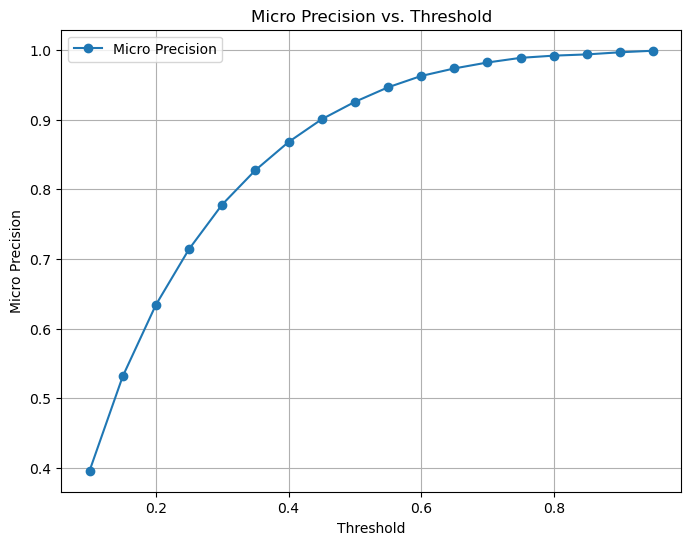

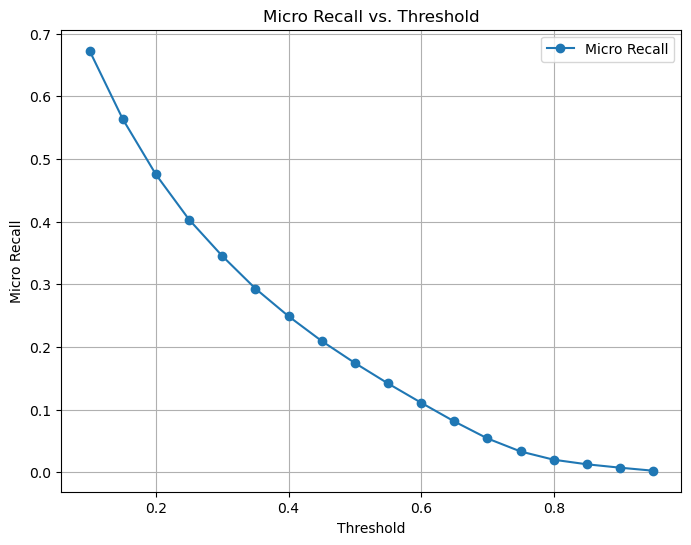

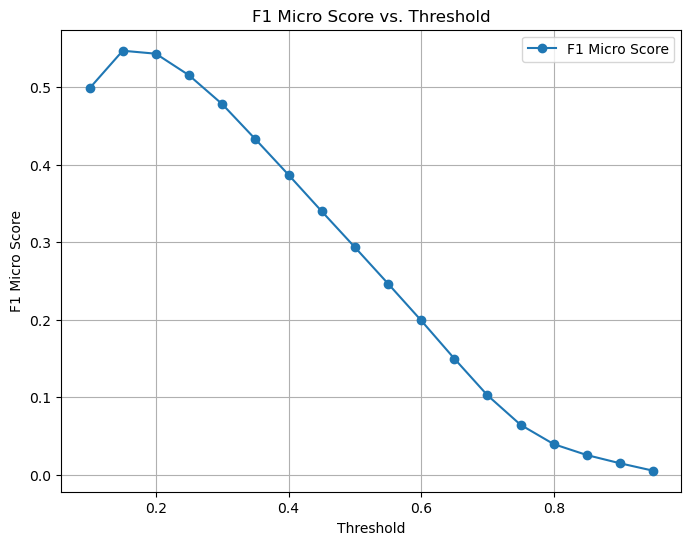

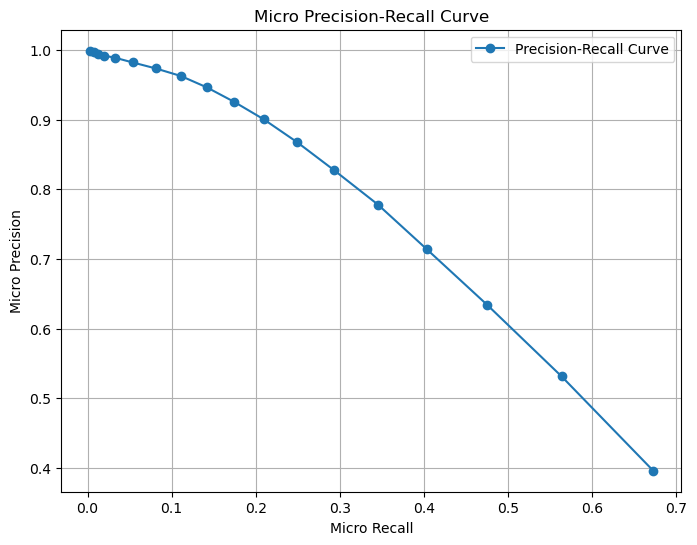

In [7]:
formatted_result_actual = []
formatted_result_pred = []

for element in full_predictions:
    single_row_pred = [0.0]*len(ALL_REDUCED_CPVS)
    single_row_actual = [0.0]*len(ALL_REDUCED_CPVS)
    cpv_found_and_scores = {}
    length_number_pred = len(element) - 1
    for single_pred in element:
        if 'actual_cpvs' in single_pred.keys():
            actual_values = single_pred["actual_cpvs"]
            for actual_value in actual_values:
                index_in_all_cpvs = ALL_REDUCED_CPVS.index(actual_value)
                single_row_actual[index_in_all_cpvs] = 1.0
        else:
            pred_values = single_pred["pred"]
            score_pred = single_pred["score"]
            for pred_value in pred_values:
                if not cpv_found_and_scores.get(pred_value):
                    cpv_found_and_scores[pred_value] = score_pred
                else:
                    cpv_found_and_scores[pred_value] = cpv_found_and_scores[pred_value] + score_pred
    for key, value in cpv_found_and_scores.items():
        index_cpv = ALL_REDUCED_CPVS.index(key)
        normalized_score = value/length_number_pred
        single_row_pred[index_cpv] = normalized_score
    formatted_result_actual.append(single_row_actual)
    formatted_result_pred.append(single_row_pred)

calculate_metrics_and_plot(formatted_result_actual, formatted_result_pred)

## Evaluation Method 2

Best F1 Micro Score: 0.69 (Threshold: 0.25)


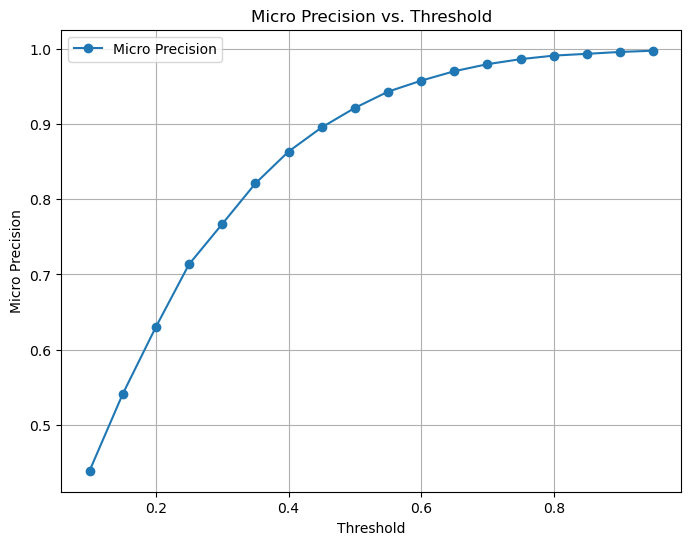

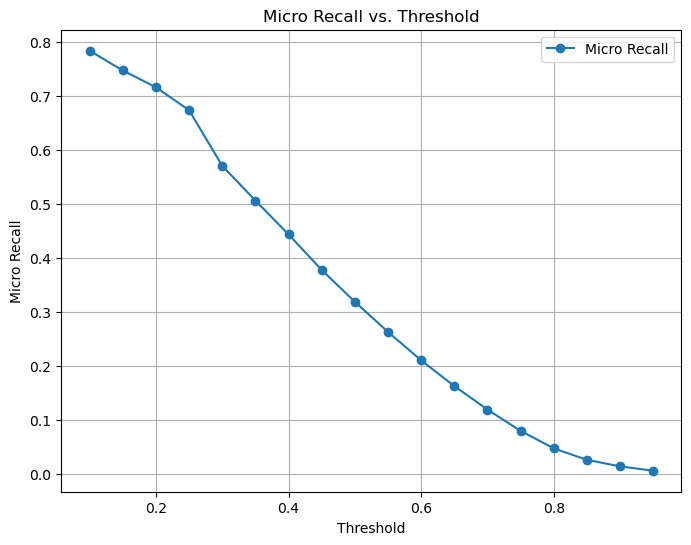

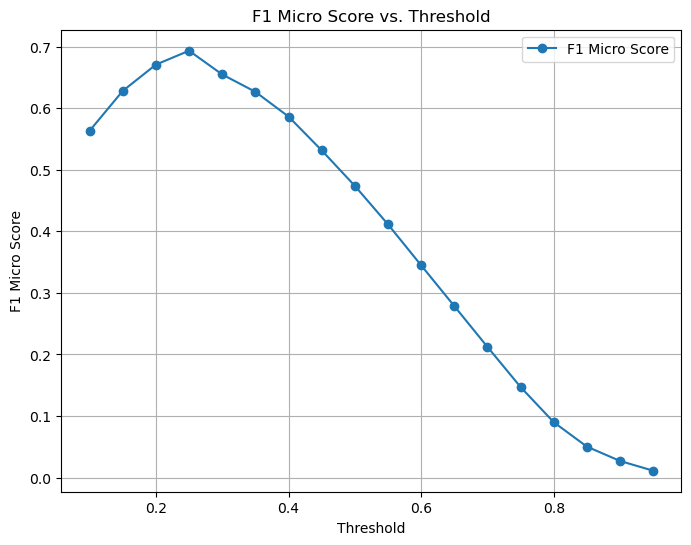

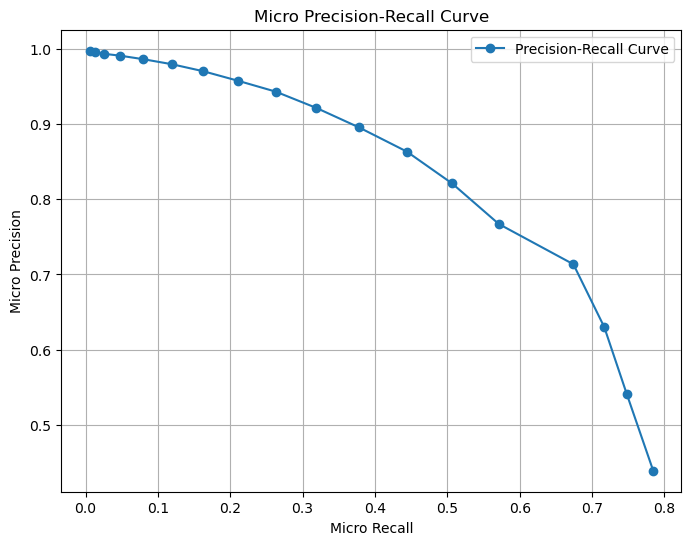

In [8]:
formatted_result_actual = []
formatted_result_pred = []
normalized_factor = 0
for i in range(1, 21):
    normalized_factor += 1/i
    
for element in full_predictions:
    single_row_pred = [0.0]*len(ALL_REDUCED_CPVS)
    single_row_actual = [0.0]*len(ALL_REDUCED_CPVS)
    cpv_found_and_scores = {}
    length_number_pred = len(element) - 1
    position = 0
    for single_pred in element:
        if 'actual_cpvs' in single_pred.keys():
            actual_values = single_pred["actual_cpvs"]
            for actual_value in actual_values:
                index_in_all_cpvs = ALL_REDUCED_CPVS.index(actual_value)
                single_row_actual[index_in_all_cpvs] = 1.0
        else:
            position += 1
            pred_values = single_pred["pred"]
            score_pred = single_pred["score"]
            for pred_value in pred_values:
                if not cpv_found_and_scores.get(pred_value):
                    cpv_found_and_scores[pred_value] = score_pred / position
                else:
                    cpv_found_and_scores[pred_value] = cpv_found_and_scores[pred_value] + (score_pred / position)
    for key, value in cpv_found_and_scores.items():
        index_cpv = ALL_REDUCED_CPVS.index(key)
        normalized_score = value/normalized_factor
        single_row_pred[index_cpv] = normalized_score
    formatted_result_actual.append(single_row_actual)
    formatted_result_pred.append(single_row_pred)

calculate_metrics_and_plot(formatted_result_actual, formatted_result_pred)

## Evaluation Method 3

Best F1 Micro Score: 0.64 (Threshold: 0.25)


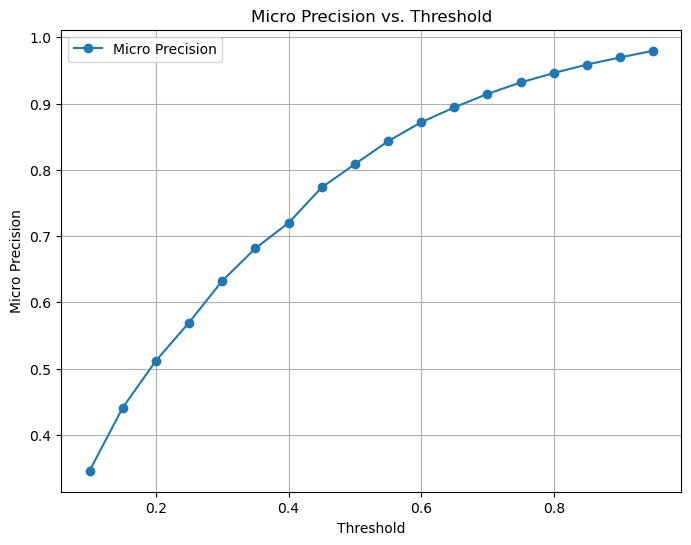

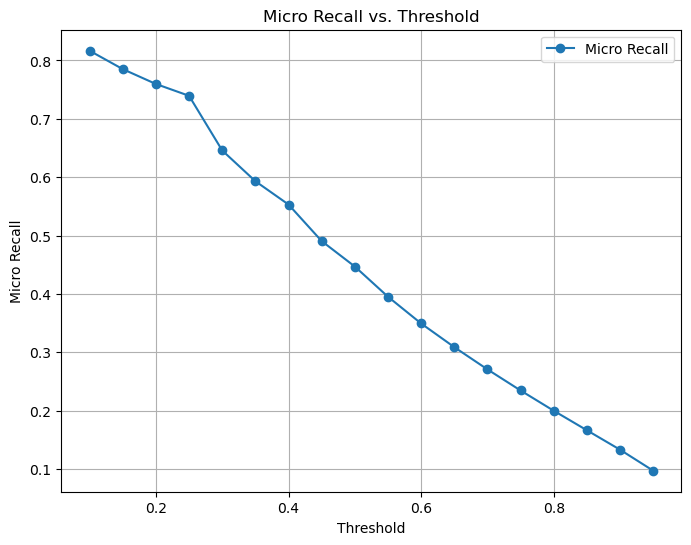

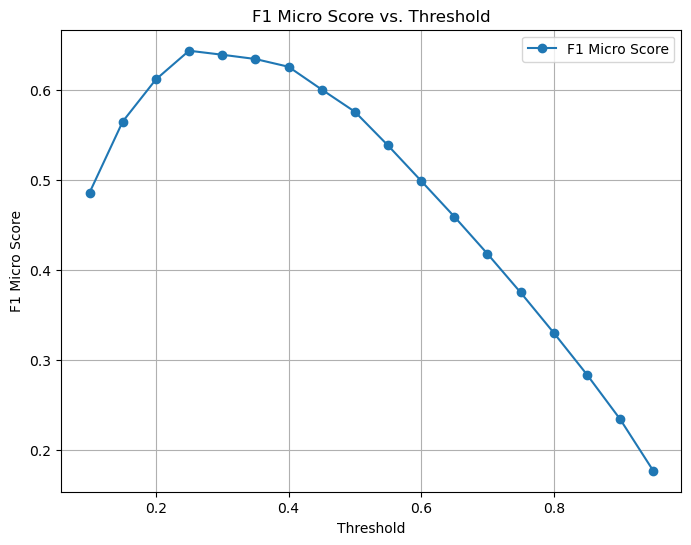

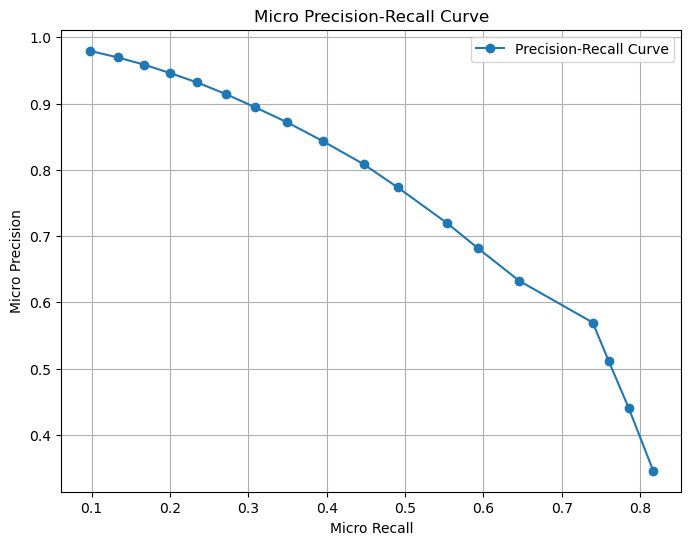

In [9]:
formatted_result_actual = []
formatted_result_pred = []
normalized_factor = 0
for i in range(1, 21):
    normalized_factor += 1/i
    
for element in full_predictions:
    single_row_pred = [0.0]*len(ALL_REDUCED_CPVS)
    single_row_actual = [0.0]*len(ALL_REDUCED_CPVS)
    cpv_found_and_scores = {}
    length_number_pred = len(element) - 1
    position = 0
    for single_pred in element:
        if 'actual_cpvs' in single_pred.keys():
            actual_values = single_pred["actual_cpvs"]
            for actual_value in actual_values:
                index_in_all_cpvs = ALL_REDUCED_CPVS.index(actual_value)
                single_row_actual[index_in_all_cpvs] = 1.0
        else:
            position += 1
            pred_values = single_pred["pred"]
            score_pred = single_pred["score"]
            for pred_value in pred_values:
                if not cpv_found_and_scores.get(pred_value):
                    cpv_found_and_scores[pred_value] = 1 / position
                else:
                    cpv_found_and_scores[pred_value] = cpv_found_and_scores[pred_value] + (1 / position)
    for key, value in cpv_found_and_scores.items():
        index_cpv = ALL_REDUCED_CPVS.index(key)
        normalized_score = value/normalized_factor
        single_row_pred[index_cpv] = normalized_score
    formatted_result_actual.append(single_row_actual)
    formatted_result_pred.append(single_row_pred)

calculate_metrics_and_plot(formatted_result_actual, formatted_result_pred)

## Evaluation Method 4

Best F1 Micro Score: 0.58 (Threshold: 0.85)


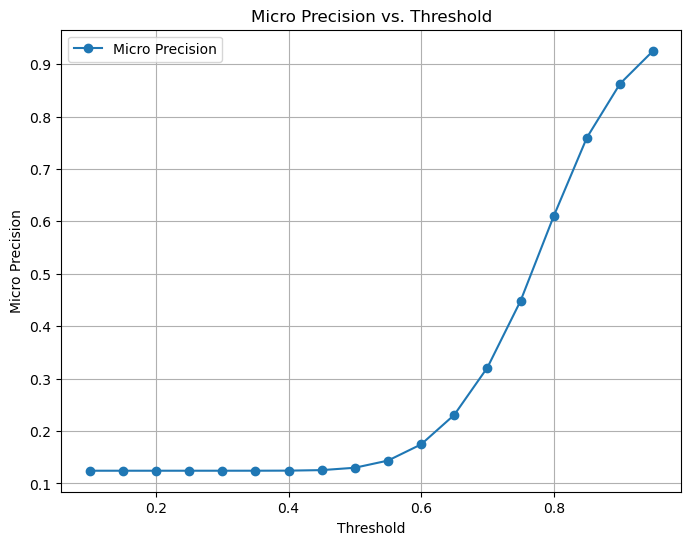

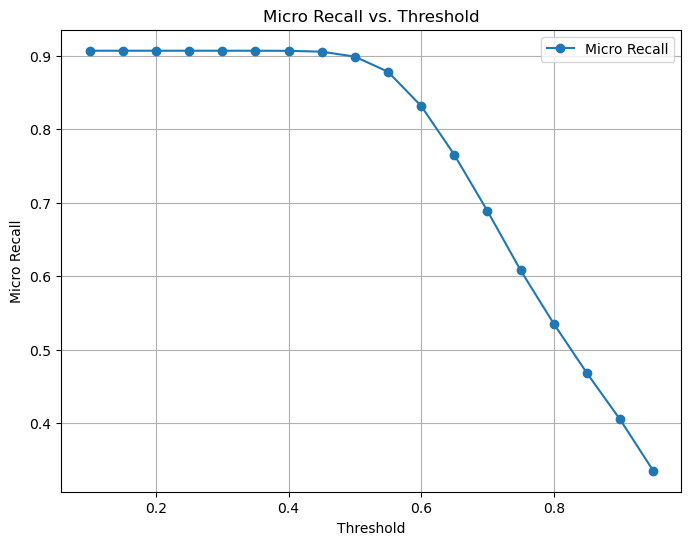

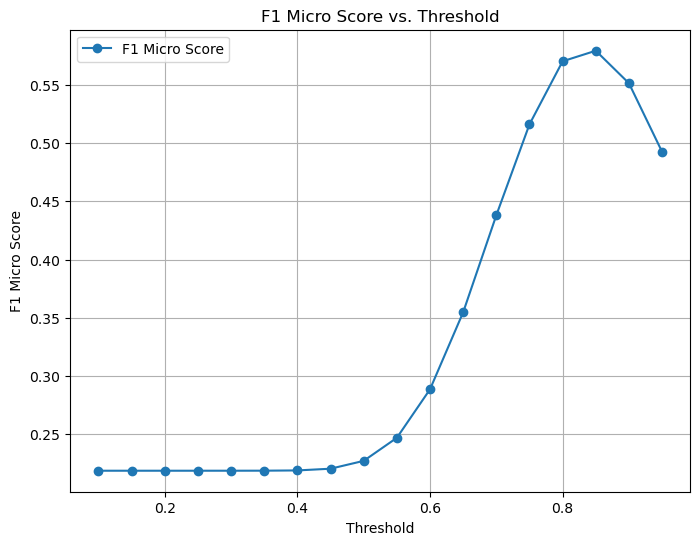

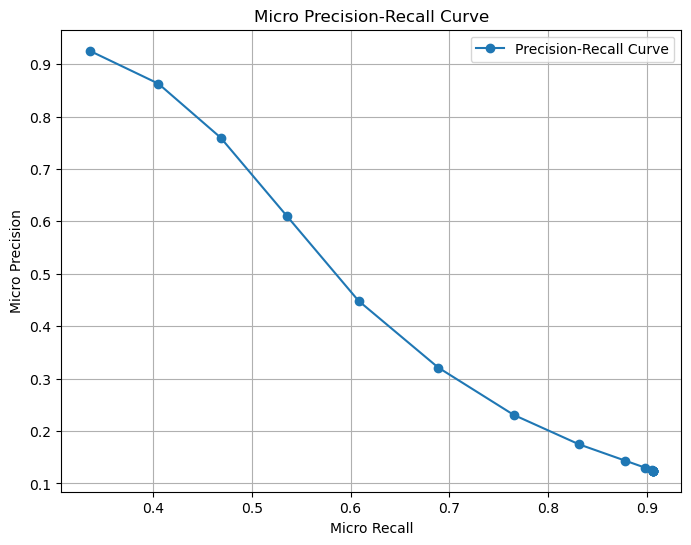

In [10]:
formatted_result_actual = []
formatted_result_pred = []

for element in full_predictions:
    single_row_pred = [0.0]*len(ALL_REDUCED_CPVS)
    single_row_actual = [0.0]*len(ALL_REDUCED_CPVS)
    cpv_found_and_scores = {}
    length_number_pred = len(element) - 1
    for single_pred in element:
        if 'actual_cpvs' in single_pred.keys():
            actual_values = single_pred["actual_cpvs"]
            for actual_value in actual_values:
                index_in_all_cpvs = ALL_REDUCED_CPVS.index(actual_value)
                single_row_actual[index_in_all_cpvs] = 1.0
        else:
            pred_values = single_pred["pred"]
            score_pred = single_pred["score"]
            for pred_value in pred_values:
                if not cpv_found_and_scores.get(pred_value):
                    cpv_found_and_scores[pred_value] = score_pred
                elif cpv_found_and_scores[pred_value] < score_pred:
                    cpv_found_and_scores[pred_value] = score_pred
    for key, value in cpv_found_and_scores.items():
        index_cpv = ALL_REDUCED_CPVS.index(key)
        single_row_pred[index_cpv] = value
    formatted_result_actual.append(single_row_actual)
    formatted_result_pred.append(single_row_pred)
    
calculate_metrics_and_plot(formatted_result_actual, formatted_result_pred)

## Evaluation Method 5

Best F1 Micro Score: 0.68 (Threshold: 0.65)


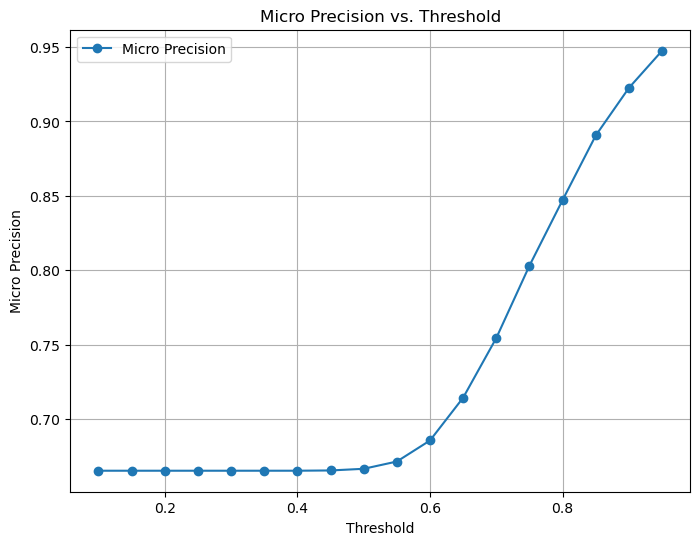

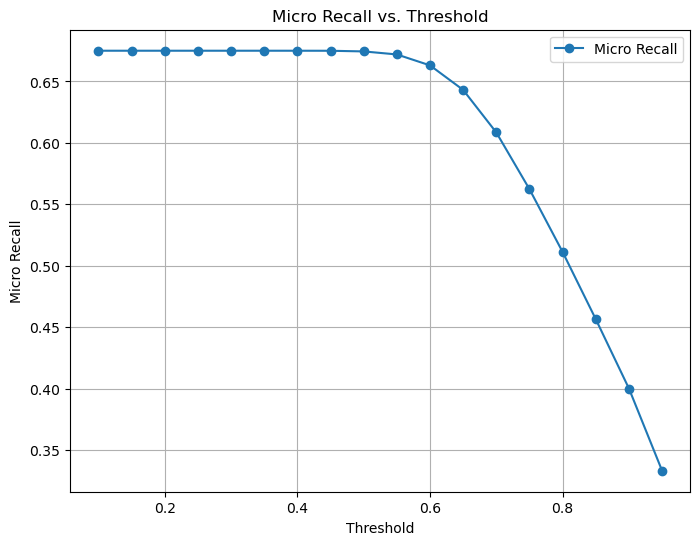

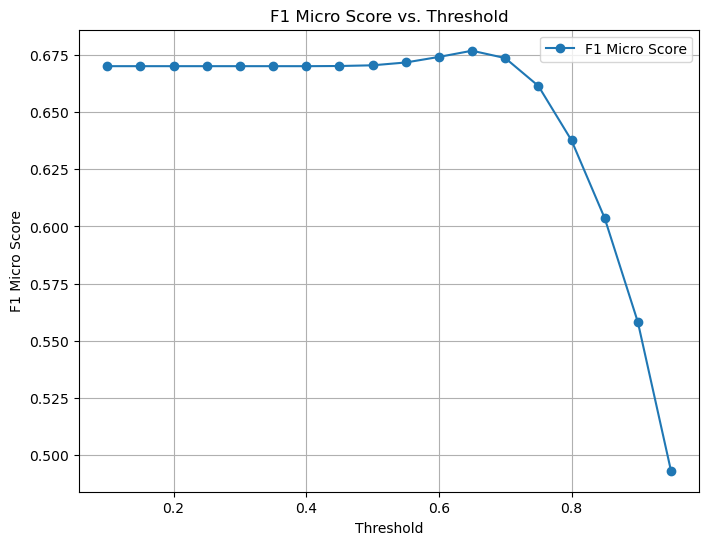

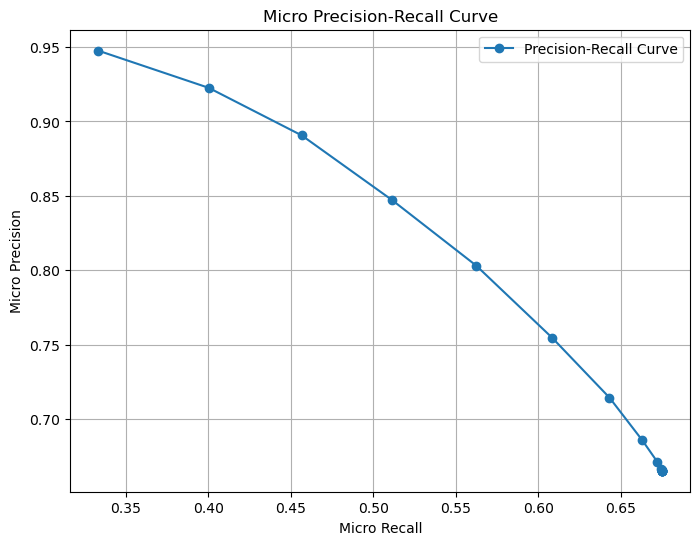

In [11]:
formatted_result_actual = []
formatted_result_pred = []

for element in full_predictions:
    single_row_pred = [0.0]*len(ALL_REDUCED_CPVS)
    single_row_actual = [0.0]*len(ALL_REDUCED_CPVS)
    cpv_found_and_scores = {}
    length_number_pred = len(element) - 1
    max_pred = []
    max_score = 0.0
    for single_pred in element:
        if 'actual_cpvs' in single_pred.keys():
            actual_values = single_pred["actual_cpvs"]
            for actual_value in actual_values:
                index_in_all_cpvs = ALL_REDUCED_CPVS.index(actual_value)
                single_row_actual[index_in_all_cpvs] = 1.0
        else:
            pred_values = single_pred["pred"]
            score_pred = single_pred["score"]
            if score_pred > max_score:
                max_score = score_pred
                max_pred = pred_values
    
    for value in max_pred:
        index_cpv = ALL_REDUCED_CPVS.index(value)
        single_row_pred[index_cpv] = max_score
    formatted_result_actual.append(single_row_actual)
    formatted_result_pred.append(single_row_pred)
    
calculate_metrics_and_plot(formatted_result_actual, formatted_result_pred)

## Multi-label report of best method
Best results have been obtained with Method 2, and a threshold of 0.25. Here follows the multi-label report.

In [13]:
formatted_result_actual = []
formatted_result_pred = []
normalized_factor = 0
for i in range(1, 21):
    normalized_factor += 1/i
    
for element in full_predictions:
    single_row_pred = [0.0]*len(ALL_REDUCED_CPVS)
    single_row_actual = [0.0]*len(ALL_REDUCED_CPVS)
    cpv_found_and_scores = {}
    length_number_pred = len(element) - 1
    position = 0
    for single_pred in element:
        if 'actual_cpvs' in single_pred.keys():
            actual_values = single_pred["actual_cpvs"]
            for actual_value in actual_values:
                index_in_all_cpvs = ALL_REDUCED_CPVS.index(actual_value)
                single_row_actual[index_in_all_cpvs] = 1.0
        else:
            position += 1
            pred_values = single_pred["pred"]
            score_pred = single_pred["score"]
            for pred_value in pred_values:
                if not cpv_found_and_scores.get(pred_value):
                    cpv_found_and_scores[pred_value] = score_pred / position
                else:
                    cpv_found_and_scores[pred_value] = cpv_found_and_scores[pred_value] + (score_pred / position)
    for key, value in cpv_found_and_scores.items():
        index_cpv = ALL_REDUCED_CPVS.index(key)
        normalized_score = value/normalized_factor
        single_row_pred[index_cpv] = normalized_score
    formatted_result_actual.append(single_row_actual)
    formatted_result_pred.append(single_row_pred)

In [14]:
from sklearn import metrics

threshold = 0.25
binary_predictions = (np.array(formatted_result_pred) >= threshold).astype(int)
print(metrics.classification_report(formatted_result_actual, binary_predictions, target_names=ALL_REDUCED_CPVS))

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        3930       0.61      0.49      0.54       250
        8033       0.74      0.65      0.69        26
        1852       0.50      0.20      0.29         5
        3850       0.73      0.66      0.70       647
        3810       0.79      0.67      0.72       183
        3521       1.00      0.56      0.71         9
        3931       0.57      0.45      0.50       129
        3365       0.76      0.87      0.81       166
        4832       0.72      0.48      0.58       130
        9210       0.65      0.55      0.60       124
        7961       0.58      0.52      0.55       157
        6017       0.75      0.80      0.77       383
        3374       0.54      0.59      0.56        56
        3225       0.71      0.54      0.62       125
        3311       0.72      0.76      0.74       344
        3011       1.00      1.00      1.00         1
        4532       0.66      0.62      0.64       164
        4460       0.69    

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
import pandas as pd
report = metrics.classification_report(formatted_result_actual, binary_predictions, target_names=ALL_REDUCED_CPVS, output_dict=True)
df = pd.DataFrame(report).transpose()
df.head()

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

precision    recall  f1-score  support
3930   0.608911  0.492000  0.544248    250.0
8033   0.739130  0.653846  0.693878     26.0
1852   0.500000  0.200000  0.285714      5.0
3850   0.733788  0.664606  0.697486    647.0
3810   0.792208  0.666667  0.724036    183.0

In [18]:
df.to_csv("classification_report_4_digits.csv")